In [1]:
import math
import random

import gym
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal

import matplotlib.pyplot as plt
from scipy import optimize, special

In [2]:
# SUS
F= np.array([[0.995860265603438,0.0378696105301410,0.00212669277812880,0.00160492825553481],
[-0.174562623798343,0.908578953704267,0.0461683633555589,0.0573094395666044],
[0.0311138708080227,0.0160492825553481,0.935759216765522,0.0151544413769853],
[1.08396104971604,0.573094395666044,-2.29631635987487,0.0906898643677941]])

I = 1.038*np.eye(4)
F = F@I
G= np.array([[0.0904767720452509],
[4.86962234417284],
[1.26376928790692],
[16.9721012819619]])

C= np.array([[1,0,0,0]])
D= 0

Gain=np.array([0.432009805187403,0.0810995504158972,-0.00516553601859450,0.00797680983779656]) 
L = np.array([[1.64402519792426],
[19.0670879046016],
[5.65550894461184],
[2.06775812635347]])


safex = np.array([[-2,-200,-100,-600],
         [2,200,100,600]])           


In [3]:
def calculate_FFG(C, G, Gain, F):
    # Element-wise multiplication of G and Gain
    G_Gain = G * Gain
    
    # Add eye(2) to G_Gain
    G_Gain_eye = G_Gain + np.eye(4)
    
    # Calculate the inverse of (G_Gain_eye - F)
    inv_G_Gain_eye_F = np.linalg.inv(G_Gain_eye - F)
    
    # Calculate C times the inverse
    C_inv_G_Gain_eye_F = C.dot(inv_G_Gain_eye_F)
    
    # Calculate FFG
    FFG = 1 / (C_inv_G_Gain_eye_F.dot(G))
    
    return FFG

In [4]:
k=1000
input_len=k
X = np.zeros((4, input_len + 1))
Xe = np.zeros((4, input_len + 1))
e = np.zeros((4, input_len))
U = np.zeros((1,input_len))
Y = np.zeros((1,input_len))
r = np.zeros((1,input_len))
z = np.zeros((1,input_len))
S = np.zeros((input_len))
n1 = np.random.normal(0,0.01,[1,input_len])      
n2 = np.random.normal(0,0.001,[4,input_len])

In [5]:
FFG = calculate_FFG(C, G, Gain, F)
Ref=1.8
X[:,0] = [0.6,10,10,10]
Xe[:,0] = [0.6,10,10,10]
for i in range(input_len):
    e[:, i] = X[:, i] - Xe[:, i]
    U[:,i] = -(Gain @ Xe[:, i])+FFG*Ref
    X[:, i+1] = F @ X[:, i] + G @ U[:, i] + n2[:, i]
    Y[:,i] = C @ X[:, i] + n1[:,i]
    r[:,i] = Y[:,i] - C @ Xe[:, i]
    Xe[:, i+1] = F @ Xe[:, i] + G @ U[:,i] + L @ r[:,i]
covn_r=np.cov(r)

In [6]:
covn_r

array(0.00038394)

In [7]:
input_len=k
X = np.zeros((4, input_len + 1))
Xe = np.zeros((4, input_len + 1))
e = np.zeros((4, input_len))
U = np.zeros((1,input_len))
Y = np.zeros((1,input_len))
r = np.zeros((1,input_len))
z = np.zeros((1,input_len))
S = np.zeros((input_len))

In [8]:
mz=[]
b=6
FFG = calculate_FFG(C, G, Gain, F)
X[:,0] = [0.6,10,10,10]
Xe[:,0] = [0.6,10,10,10]
for i in range(input_len):
    e[:, i] = X[:, i] - Xe[:, i]
    U[:,i] = -(Gain @ Xe[:, i])+FFG*Ref
    X[:, i+1] = F @ X[:, i] + G @ U[:, i] + n2[:, i]
    Y[:,i] = C @ X[:, i] + n1[:,i]
    r[:,i] = Y[:,i] - C @ Xe[:, i]
    Xe[:, i+1] = F @ Xe[:, i] + G @ U[:,i] + L @ r[:,i]
    z[:,i] = r[:,i].T * (covn_r)**(-1) * r[:,i]
    mz.append(z[:,i])
    if i>0:
        S[i] = max(S[i-1] + z[:,i] - b,0)

In [ ]:
z_mean=np.array([])
z_var=np.array([])
sums=0
for i in range(len(mz)):
    sums+=mz[i]
    mean=sums/(i+1)
    var=np.var(mz[:i+1])
    z_mean=np.append(z_mean,mean)
    z_var=np.append(z_var,var)

In [9]:
t=10
b=6
q=-b**(1/2)

In [10]:
input_len=k
Xk = np.zeros((4, input_len + 1))
Xek = np.zeros((4, input_len + 1))
ek = np.zeros((4, input_len))    
Uk = np.zeros((1,input_len))
Yk = np.zeros((1,input_len))
attack= np.zeros((1,input_len))
rk = np.zeros((1,input_len))
zk = np.zeros((1,input_len))
Sk = np.zeros((input_len))
Xk[:,0] = [0.6,10,10,10]
Xek[:,0] = [0.6,10,10,10]
FFG = calculate_FFG(C, G, Gain, F)
mzk=[]
for i in range(input_len):
    ek[:, i] = Xk[:, i] - Xek[:, i]
    Uk[:,i] = -(Gain @ Xek[:, i])+FFG*Ref
    Xk[:, i+1] = F @ Xk[:, i] + G @ Uk[:, i] + n2[:, i]
    if i==200:
        p=-(t+b-Sk[i-1])**(1/2)
        attack[:,i]=-C@ek[:, i]-n1[:, i]+(covn_r**(1/2))*p
    elif i>200:
        attack[:,i]=-C@ek[:, i]-n1[:, i]+(covn_r**(1/2))*q
    Yk[:,i] = C @ Xk[:, i] + n1[:,i] + attack[:,i]
    rk[:,i] = Yk[:,i] - C @ Xek[:, i]
    Xek[:, i+1] = F @ Xek[:, i] + G @ Uk[:,i] + L @ rk[:,i]
    zk[:,i] = rk[:,i].T * (covn_r)**(-1) * rk[:,i]
    mzk.append(zk[:,i])
    if i>0:
        Sk[i] = max(0,Sk[i-1] + zk[:,i] - b)

In [11]:
input_len=k
Xkt = np.zeros((4, input_len + 1))
Xekt = np.zeros((4, input_len + 1))
ekt = np.zeros((4, input_len))    
Ukt = np.zeros((1,input_len))
Ykt = np.zeros((1,input_len))
rkt = np.zeros((1,input_len))
zkt = np.zeros((1,input_len))
meankt = np.zeros((input_len,))
Skt = np.zeros((input_len))
Xkt[:,0] = [0.6,10,10,10]
Xekt[:,0] = [0.6,10,10,10]
FFG = calculate_FFG(C, G, Gain, F)
sums=0
for i in range(input_len):
    ekt[:, i] = Xkt[:, i] - Xekt[:, i]
    Ukt[:,i] = -(Gain @ Xekt[:, i])+FFG*Ref
    Xkt[:, i+1] = F @ Xkt[:, i] + G @ Ukt[:, i] + n2[:, i]
    Ykt[:,i] = C @ Xkt[:, i] + n1[:,i] + attack[:,i]
    rkt[:,i] = Ykt[:,i] - C @ Xekt[:, i]
    Xekt[:, i+1] = F @ Xekt[:, i] + G @ Ukt[:,i] + L @ rkt[:,i]
    zkt[:,i] = rkt[:,i].T * (covn_r)**(-1) * rkt[:,i]
    sums+=zkt[:,i]
    meankt[i]=sums/(i+1)
    if i>100:
        if (meankt[i]>1.5 or meankt[i]<0.5):
            b=b/1.2
    if i>0:
        Skt[i]=max(Skt[i-1]+zkt[:,i]-b,0)

In [ ]:
zk_mean=np.array([])
zk_var=np.array([])
sums=0
for i in range(len(mzk)):
    sums+=mzk[i]
    var=np.var(mzk[:i+1])
    mean=sums/(i+1)
    zk_mean=np.append(zk_mean,mean)
    zk_var=np.append(zk_var,var)

In [ ]:
y=[10]*len(S)
fig, axs = plt.subplots(4, 2, figsize=(16, 12))

#state without attack
axs[0, 0].plot(np.arange(0,k), X[0,:-1], color='blue')
axs[0, 0].set_title('State without Attack')
axs[0, 0].set_ylabel('State')

#state with attack
axs[0, 1].plot(np.arange(0,k), Xk[0,:-1], color='blue')
axs[0, 1].set_title('State with Attack')
axs[0, 1].set_ylabel('State')

#cusum without attack
axs[1, 0].plot(np.arange(0,len(S)), S, color='blue')
axs[1,0].plot(np.arange(0,len(S)),y,color='yellow')
axs[1, 0].set_title('Cusum without Attack')
axs[1, 0].set_ylabel('Cusum')

#cusum with attack
axs[1, 1].plot(np.arange(0,len(Sk)), Sk, color='blue')
axs[1,1].plot(np.arange(0,len(S)),y,color='yellow')
axs[1, 1].set_title('Cusum with Attack')
axs[1, 1].set_ylabel('Cusum')

#plot mean without attack
axs[2, 0].plot(np.arange(0,len(z_mean)), z_mean, color='blue')
axs[2, 0].set_title('Z_Mean without Attack')
axs[2, 0].set_ylabel('Mean')

# Plot variance without attack
axs[3, 0].plot(np.arange(0,len(z_var)), z_var, color='blue')
axs[3, 0].set_title('Z_Variance without Attack')
axs[3, 0].set_ylabel('Variance')

# Plot mean with attack
axs[2, 1].plot(np.arange(0,input_len), zk_mean, color='red')
axs[2, 1].set_title('Z_Mean with Attack')
axs[2, 1].set_ylabel('Mean')

# Plot variance with attack
axs[3, 1].plot(np.arange(0,input_len), zk_var, color='red')
axs[3, 1].set_title('Z_Variance with Attack')
axs[3, 1].set_ylabel('Variance')

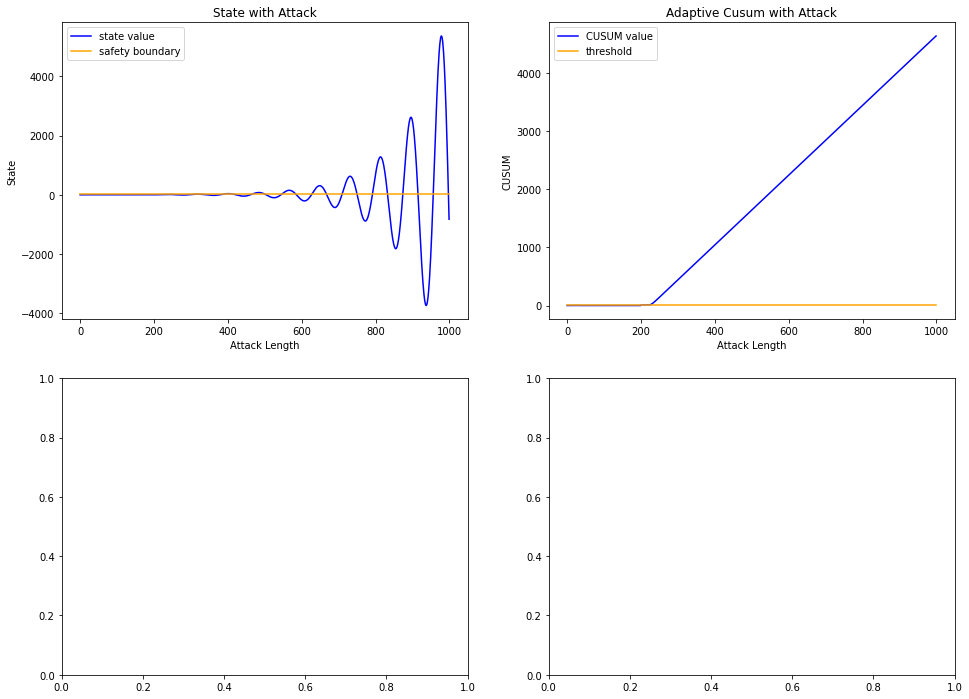

In [12]:
y=[t]*len(Skt)
safe=[26]*len(Xkt[0,:-1])
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

#state without attack
axs[0, 0].plot(np.arange(0,k), Xkt[0,:-1], color='blue',label='state value')
axs[0,0].plot(np.arange(0,len(Xkt[0,:-1])),safe,color='orange',label='safety boundary')
axs[0, 0].set_title('State with Attack')
axs[0, 0].set_ylabel('State')
axs[0, 0].set_xlabel('Attack Length')
axs[0, 0].legend()
#state with attack
axs[0, 1].plot(np.arange(0,len(Skt)), Skt, color='blue',label='CUSUM value')
axs[0,1].plot(np.arange(0,len(Skt)),y,color='orange',label='threshold')
axs[0, 1].set_title('Adaptive Cusum with Attack')
axs[0, 1].set_ylabel('CUSUM')
axs[0, 1].set_xlabel('Attack Length')
axs[0, 1].legend()

In [ ]:
import pandas as pd
Table1=pd.DataFrame(columns=['X1','X2','X3','X4','Xf1','Xf2','Xf3','Xf4','i'])
Table2=pd.DataFrame(columns=['X1','X2','X3','X4','Xf1','Xf2','Xf3','Xf4','i'])

In [ ]:
t=10
b=6
q1=-b**(1/2)
q2=b**(1/2)

In [ ]:
for j in range(100):
    input_len=500
    Xk = np.zeros((4, input_len + 1))
    Xek = np.zeros((4, input_len + 1))
    ek = np.zeros((4, input_len))    
    Uk = np.zeros((1,input_len))
    Yk = np.zeros((1,input_len))
    attack= np.zeros((1,input_len))
    rk = np.zeros((1,input_len))
    zk = np.zeros((1,input_len))
    Sk = np.zeros((input_len))
    Xk[:,0] = [0.6,10,10,10]
    Xek[:,0] = [0.6,10,10,10]
    FFG = calculate_FFG(C, G, Gain, F)
    Ref=1.8*(0.95)**j
    for i in range(input_len):
        ek[:, i] = Xk[:, i] - Xek[:, i]
        Uk[:,i] = -(Gain @ Xek[:, i])+FFG*Ref
        Xk[:, i+1] = F @ Xk[:, i] + G @ Uk[:, i] + n2[:, i]
        if i==200:
            p1=-(t+b-Sk[i-1])**(1/2)
            Table1.loc[j,'X1']=Xk[0,i]
            Table1.loc[j,'X2']=Xk[1,i]
            Table1.loc[j,'X3']=Xk[2,i]
            Table1.loc[j,'X4']=Xk[3,i]
            attack[:,i]=-C@ek[:, i]-n1[:, i]+(covn_r**(1/2))*p1
        elif i>200:
            attack[:,i]=-C@ek[:, i]-n1[:, i]+(covn_r**(1/2))*q1
        Yk[:,i] = C @ Xk[:, i] + n1[:,i] + attack[:,i]
        rk[:,i] = Yk[:,i] - C @ Xek[:, i]
        Xek[:, i+1] = F @ Xek[:, i] + G @ Uk[:,i] + L @ rk[:,i]
        zk[:,i] = rk[:,i].T * (covn_r)**(-1) * rk[:,i]
        mzk.append(zk[:,i])
        if i>100:
            if Xk[0][i]>2 or Xk[0][i]<-2 or Xk[1][i]>200 or Xk[1][i]<-200:
                Table1.loc[j,'Xf1']=Xk[0,i]
                Table1.loc[j,'Xf2']=Xk[1,i]
                Table1.loc[j,'Xf3']=Xk[2,i]
                Table1.loc[j,'Xf4']=Xk[3,i]
                Table1.loc[j,'i']=i
                break
    
    if i>0:
        Sk[i]=max(Sk[i-1]+zk[:,i]-b,0)
    if Sk[i]>t:
        print(i)
        print("attack detected")
        break

In [ ]:
for j in range(100):
    input_len=k
    Xk = np.zeros((4, input_len + 1))
    Xek = np.zeros((4, input_len + 1))
    ek = np.zeros((4, input_len))    
    Uk = np.zeros((1,input_len))
    Yk = np.zeros((1,input_len))
    attack= np.zeros((1,input_len))
    rk = np.zeros((1,input_len))
    zk = np.zeros((1,input_len))
    Sk = np.zeros((input_len))
    Xk[:,0] = [-0.6,-10,-10,-10]
    Xek[:,0] = [-0.6,-10,-10,-10]
    FFG = calculate_FFG(C, G, Gain, F)
    Ref=-1.8*(0.95)**j
    for i in range(input_len):
        ek[:, i] = Xk[:, i] - Xek[:, i]
        Uk[:,i] = -(Gain @ Xek[:, i])+FFG*Ref
        Xk[:, i+1] = F @ Xk[:, i] + G @ Uk[:, i] + n2[:, i]
        if i==200:
            p2=(t+b-Sk[i-1])**(1/2)
            Table2.loc[j,'X1']=Xk[0,i]
            Table2.loc[j,'X2']=Xk[1,i]
            Table2.loc[j,'X3']=Xk[2,i]
            Table2.loc[j,'X4']=Xk[3,i]
            attack[:,i]=-C@ek[:, i]-n1[:, i]+(covn_r**(1/2))*p2
        elif i>200:
            attack[:,i]=-C@ek[:, i]-n1[:, i]+(covn_r**(1/2))*q2
        Yk[:,i] = C @ Xk[:, i] + n1[:,i] + attack[:,i]
        rk[:,i] = Yk[:,i] - C @ Xek[:, i]
        Xek[:, i+1] = F @ Xek[:, i] + G @ Uk[:,i] + L @ rk[:,i]
        zk[:,i] = rk[:,i].T * (covn_r)**(-1) * rk[:,i]
        mzk.append(zk[:,i])
        if i>100:
            if Xk[0][i]>2 or Xk[0][i]<-2 or Xk[1][i]>200 or Xk[1][i]<-200:
                Table2.loc[j,'Xf1']=Xk[0,i]
                Table2.loc[j,'Xf2']=Xk[1,i]
                Table2.loc[j,'Xf3']=Xk[2,i]
                Table2.loc[j,'Xf4']=Xk[3,i]
                Table2.loc[j,'i']=i
                break
    
    if i>0:
        Sk[i]=max(Sk[i-1]+zk[:,i]-b,0)

In [ ]:
from sklearn.linear_model import LinearRegression
X=np.array(Table1.loc[:,'X1'].values.reshape(-1,1))
y=np.array(Table1.loc[:,'i'].values)
# Initialize and fit the model
model1 = LinearRegression()
model1.fit(X, y)

# Get the slope (coefficients) and intercept
slope1 = model1.coef_[0]
intercept1 = model1.intercept_

print("Slope:", slope1)
print("Intercept:", intercept1)


In [ ]:
from sklearn.linear_model import LinearRegression
X=np.array(Table2.loc[:,'X1'].values.reshape(-1,1))
y=np.array(Table2.loc[:,'i'].values)
# Initialize and fit the model
model2 = LinearRegression()
model2.fit(X, y)

# Get the slope (coefficients) and intercept
slope2 = model2.coef_[0]
intercept2 = model2.intercept_

print("Slope:", slope2)
print("Intercept:", intercept2)


In [ ]:
Table=pd.concat([Table1,Table2])
Table

In [ ]:
import matplotlib.pyplot as plt


# Generate x values
x_values = np.arange(-2,3)

# Calculate y values using the linear equation y = mx + b
y1_values = slope1 * x_values + intercept1
y2_values = slope2* x_values + intercept2
data_x= np.array(Table.loc[:,'X1'].values)
data_y=np.array(Table.loc[:,'i'].values)
# Plot the graph
plt.plot(x_values,np.minimum(y1_values,y2_values), label='Linear Fit')
plt.scatter(data_x, data_y, color='red',s=10, label='Data Points') 
plt.xlabel('X1')
plt.ylabel('attack_length')
plt.title('Suspension Controller-Linear Regression Plot')
plt.grid(True)
plt.legend()

plt.show()


In [ ]:
Table[150:200]

In [ ]:
data=pd.DataFrame(columns=['max','min','attack_length'])
data.loc[0,:]=[1.8,0.2,205]
data.loc[1,:]=[0.2,0,211]
data.loc[2,:]=[-0.6,-1.8,204]
data.loc[3,:]=[0,-0.6,209]
data

In [ ]:
data.to_excel('data_part1.xlsx')